<a href="https://colab.research.google.com/github/milad-s5/-Joint-Object-Detection-and-Depth-Estimation-in-Image-/blob/main/Joint_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
cd 'drive/MyDrive/Colab Notebooks/DL/project/'

/content/drive/MyDrive/Colab Notebooks/DL/project


In [3]:
# Make data directory if it doesn't exist
!mkdir -p dataset
!wget -nc "http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat" -P dataset

File ‘dataset/nyu_depth_v2_labeled.mat’ already there; not retrieving.



In [20]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 7.5 MB/s 


# Preprocessing

Labeled dataset (~2.8 GB):
* ***depths*** – HxWxN matrix of in-painted depth maps where H and W are the height and width, respectively and N is the number of images. The values of the depth elements are in meters.
* ***images*** – HxWx3xN matrix of RGB images where H and W are the height and width, respectively, and N is the number of images.
* ***labels*** – HxWxN matrix of object label masks where H and W are the height and width, respectively and N is the number of images. The labels range from 1..C where C is the total number of classes. If a pixel’s label value is 0, then that pixel is ‘unlabeled’.
* accelData – Nx4 matrix of accelerometer values indicated when each frame was taken. The columns contain the roll, yaw, pitch and tilt angle of the device.
* instances – HxWxN matrix of instance maps. Use get_instance_masks.m in the Toolbox to recover masks for each object instance in a scene.
* names – Cx1 cell array of the english names of each class.
* namesToIds – map from english label names to class IDs (with C key-value pairs)
* rawDepths – HxWxN matrix of raw depth maps where H and W are the height and width, respectively, and N is the number of images. These depth maps capture the depth images after they have been projected onto the RGB image plane but before the missing depth values have been filled in. Additionally, the depth non-linearity from the Kinect device has been removed and the values of each depth image are in meters.
* rawDepthFilenames – Nx1 cell array of the filenames (in the Raw dataset) that were used for each of the depth images in the labeled dataset.
* rawRgbFilenames – Nx1 cell array of the filenames (in the Raw dataset) that were used for each of the RGB images in the labeled dataset.
* scenes – Nx1 cell array of the name of the scene from which each image was taken.
* sceneTypes – Nx1 cell array of the scene type from which each image was taken.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
import h5py
import os

In [7]:
f=h5py.File("dataset/nyu_depth_v2_labeled.mat")
images=f["images"]
labels=f["labels"]
images=np.array(images)
 
path_converted='./nyu/nyu_images'
if not os.path.isdir(path_converted):
    os.makedirs(path_converted)
 
images_number=[]
for i in range(len(images)):
    images_number.append(images[i])
    a=np.array(images_number[i])
    r = Image.fromarray(a[0]).convert('L') # convert to gray
    g = Image.fromarray(a[1]).convert('L')
    b = Image.fromarray(a[2]).convert('L')
    img = Image.merge("RGB", (r, g, b))
    img = img.transpose(Image.ROTATE_270)
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    iconpath='./nyu/nyu_images/'+str(i)+'.jpg'
    img.save(iconpath,optimize=True)

In [8]:
depths=f["depths"]
depths=np.array(depths)
 
path_converted='./nyu/nyu_depths/'
if not os.path.isdir(path_converted):
    os.makedirs(path_converted)
 
maxd = depths.max()
print('max depths(m) =',depths.max())
print('min depths(m) =',depths.min())
 
depths = depths / maxd * 255
depths = depths.transpose((0,2,1))
 
print('max depths =',depths.max())
print('min depths =',depths.min())
 
for i in range(len(depths)):
    depths_img= Image.fromarray(np.uint8(depths[i]))
    iconpath=path_converted + str(i)+'.png'
    depths_img.save(iconpath, 'PNG', optimize=True)

max depths(m) = 9.99547
min depths(m) = 0.7132995
max depths = 255.0
min depths = 18.197382


In [ ]:
labels=f["labels"]
labels=np.array(labels)
 
path_converted='./nyu/nyu_labels/'
if not os.path.isdir(path_converted):
    os.makedirs(path_converted)
 
labels_number = []
for i in range(len(labels)):
    labels_number.append(labels[i])
    labels_0 = np.array(labels_number[i])
    label_img = Image.fromarray(np.uint8(labels_number[i]))
    label_img = label_img.transpose(Image.ROTATE_270)
    label_img = label_img.transpose(Image.FLIP_LEFT_RIGHT)    

    iconpath = './nyu/nyu_labels/' + str(i) + '.png'
    label_img.save(iconpath, 'PNG', optimize=True)

In [10]:
imgs_list = (os.listdir(os.path.join('./nyu', 'nyu_images')))
imgdepths_list = (os.listdir(os.path.join('./nyu', 'nyu_depths')))

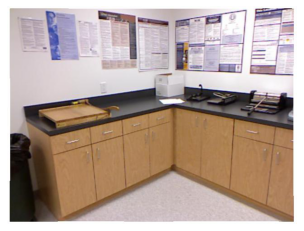

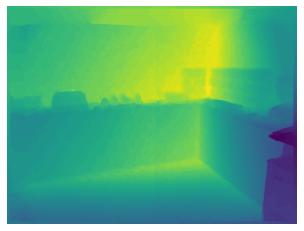

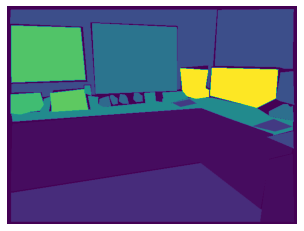

In [11]:
plt.imshow(plt.imread('./nyu/nyu_images/'+imgs_list[0]))
plt.axis("off")
plt.show()

plt.imshow(plt.imread('./nyu/nyu_depths/'+imgdepths_list[0]))
plt.axis("off")
plt.show()

plt.imshow(plt.imread('./nyu/nyu_labels/'+imgdepths_list[0]))
plt.axis("off")
plt.show()

In [12]:
print(np.max(plt.imread('./nyu/nyu_depths/'+imgdepths_list[0])))
print(np.max(plt.imread('./nyu/nyu_images/'+imgs_list[0])))

0.3647059
255


# Depth estimation

In [50]:
import pandas as pd
import os, time
import shutil
import sys
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import random
# Model
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, concatenate, Concatenate, Input
from tensorflow.keras import Model
from keras.models import model_from_json
# Opt
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

In [51]:
#Hyper params
split = 0.8
split_test = 0.1
height, width = 240, 320 

In [52]:
path = "./nyu"

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()

data = {
    "image": [x for x in filelist if x.startswith("./nyu/nyu_images")],
    "depth": [x for x in filelist if x.startswith("./nyu/nyu_depths")],
}
df = pd.DataFrame(data)

train_split = int(len(df)*split)
validation_split = int(len(df)*split_test)
test_split = len(df) - train_split - validation_split
# train, test, validatoin
train = df[:train_split]
validation = df[train_split:train_split+validation_split]
test = df[len(df)-test_split:]

#df = df.sample(frac=1, random_state=42)
len(train), len(validation), len(test)

(1159, 144, 146)

In [53]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, dataframe, batch_size, shuffle=False, dim=(320,240)):
    # for reproducibility
    np.random.seed(43)
    # dataframe containing the subset of image and depth pairs
    self.df = dataframe
    # chosen Height and Width of the RGB image
    self.height, self.width = dim
    # choice of shuffling the data
    self.shuffle = shuffle
    self.batch_size = batch_size
    # unique set of RGB images
    self.ids = dataframe['image'].unique()
    # Map the image with depth maps
    self.imgtodpth = dataframe.set_index('image')['depth'].to_dict()
    self.on_epoch_end()

  def __len__(self):
    return len(self.df) // self.batch_size

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.ids))
    if self.shuffle:
      np.random.shuffle(self.indexes)
  
  def __getitem__(self,index):
    # select the batch of pair indexes 
    idxs = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
    # randomly select whether to flip the image
    flip = np.random.choice([True, False])
    # select the image id's for the above indexes
    query_imgs = [self.ids[idx] for idx in idxs]
    # select corresponding depth pair for the image
    target_imgs = [self.imgtodpth[img] for img in query_imgs]
    # preprocess the image 
    processed_query_img = self._preprocess_image(query_imgs, flip)
    # preprocess the depth map
    processed_depth_img = self._preprocess_depth(target_imgs, flip)
    return processed_query_img, processed_depth_img

  def _preprocess_image(self,images, flip):
    # placeholder for storing the processed images
    processed = []
    for img in images:
      # resize the image to 640x480
      resized_img = cv2.resize(cv2.imread(img),(self.height,self.width)).astype(np.float32)
      # normalize the image to {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # finally append each image
      processed.append(scaled_img)
    return np.array(processed)

  def _preprocess_depth(self,images, flip):
    # placeholder for storing the processed depth maps
    processed = []
    for img in images:
      # resize the depth map to 320x240
      resized_img = cv2.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY),(320,240)).astype(np.float32)
      # normalize it to range {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # add the color channel as cv2 grayscale image doesnt contain color channel but tensorflow expects it
      scaled_img = np.expand_dims(scaled_img, axis=-1)
      # finally append the image
      processed.append(scaled_img)
    return np.array(processed)

In [54]:
train_generator = DataGenerator(train, batch_size=4, shuffle=True, dim=(640,480))
val_generator = DataGenerator(validation, batch_size=4, shuffle=False, dim=(640,480))
test_generator = DataGenerator(test, batch_size=16, shuffle=False, dim=(640,480))
print(len(train_generator), len(val_generator), len(test_generator))

289 36 9


In [55]:
images,depths = next(iter(val_generator))
print(images.shape, depths.shape)

(4, 480, 640, 3) (4, 240, 320, 1)


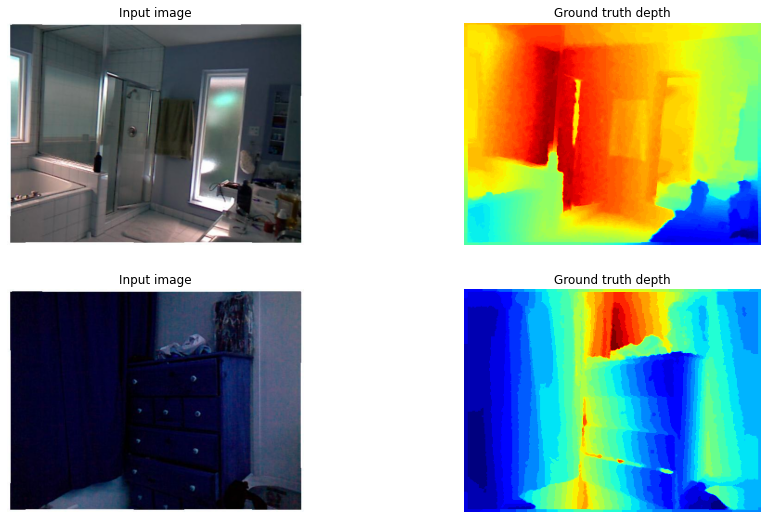

In [57]:
cmap = plt.cm.jet
cmap.set_bad(color="black")

plt.figure(figsize=(15,9))
for i in range(0,4,2):
  image = images[i]
  depth = depths[i].squeeze(-1)
  plt.subplot(221+i)
  plt.axis('off')
  plt.imshow(image)
  plt.title('Input image')
  plt.subplot(222+i)
  plt.axis('off')
  plt.imshow(depth,cmap=plt.get_cmap(cmap))
  plt.title('Ground truth depth')

In [58]:
# Model
def upsampling(input_tensor, n_filters, concat_layer):
  '''
  Block of Decoder
  '''
  # Bilinear 2x upsampling layer
  x = UpSampling2D(size=(2,2), interpolation='bilinear')(input_tensor)
  # concatenation with encoder block 
  x = concatenate([x,concat_layer])
  # decreasing the depth filters by half
  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
  x = BatchNormalization()(x)
  return x

# Layer name of encoders to be concatenated
names = ['pool3_pool', 'pool2_pool', 'pool1','conv1/relu']
# Transfer learning approach without the classification head
encoder = DenseNet169(include_top=False, weights='imagenet', input_shape=(480,640,3))
for layer in encoder.layers:
  layer.trainable = True
inputs = encoder.input
x = encoder.output
# decoder blocks linked with corresponding encoder blocks
bneck = Conv2D(filters=1664, kernel_size=(1,1), padding='same')(x)
x = LeakyReLU(alpha=0.2)(bneck)
x = upsampling(bneck, 832, encoder.get_layer(names[0]).output)
x = LeakyReLU(alpha=0.2)(x)
x = upsampling(x, 416, encoder.get_layer(names[1]).output)
x = LeakyReLU(alpha=0.2)(x)
x = upsampling(x, 208, encoder.get_layer(names[2]).output)
x = LeakyReLU(alpha=0.2)(x)
x = upsampling(x, 104, encoder.get_layer(names[3]).output)
x = Conv2D(filters=1, activation='sigmoid', kernel_size=(3,3), padding='same')(x)

model = Model(inputs=inputs, outputs=x)
model.summary()

51888128/51877672 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 486, 646, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 240, 320, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [59]:
def loss_function(y_true, y_pred):

  #Cosine distance loss
  l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
  
  # edge loss for sharp edges
  dy_true, dx_true = tf.image.image_gradients(y_true)
  dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
  
  # structural similarity loss
  l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  # weightage
  w1, w2, w3 = 1.0, 1.0, 0.1
  return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

#optimizer
opt = tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-6,amsgrad=True)

# accuracy function
def accuracy_function(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# Learning rate scheduler
def polynomial_decay(epoch):
  max_epochs = 10
  base_lr =  0.0001
  power = 1.0
  lr = base_lr * (1 - (epoch / float(max_epochs))) ** power
  return lr

callbacks = [LearningRateScheduler(polynomial_decay, verbose=0)]


In [60]:
for layer in encoder.layers:
  layer.trainable = True

In [ ]:
model.compile(optimizer=opt, loss=loss_function, metrics=[accuracy_function])
history = model.fit(train_generator, validation_data=val_generator, epochs=3,callbacks=callbacks)

Epoch 1/3
289/289 [==============================] - 1325s 4s/step - loss: 0.1759 - accuracy_function: 0.7298 - val_loss: 0.2361 - val_accuracy_function: 0.7678 - lr: 1.0000e-04
Epoch 2/3
289/289 [==============================] - 759s 3s/step - loss: 0.1519 - accuracy_function: 0.7783 - val_loss: 0.1557 - val_accuracy_function: 0.7698 - lr: 9.0000e-05
Epoch 3/3
289/289 [==============================] - 757s 3s/step - loss: 0.1376 - accuracy_function: 0.8101 - val_loss: 0.1543 - val_accuracy_function: 0.7849 - lr: 8.0000e-05


In [ ]:
model.evaluate(train_generator)

289/289 [==============================] - 220s 761ms/step - loss: 0.1345 - accuracy_function: 0.8420


[0.1344933658838272, 0.8419879674911499]

## Test generator

In [ ]:
model.evaluate(test_generator)

9/9 [==============================] - 130s 13s/step - loss: 0.1427 - accuracy_function: 0.7962


[0.14265143871307373, 0.7961776256561279]

In [ ]:
images,labels = next(iter(test_generator))
preds = model.predict(images)

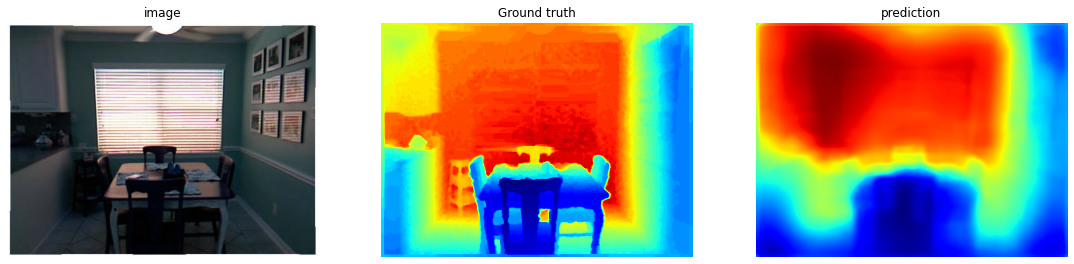

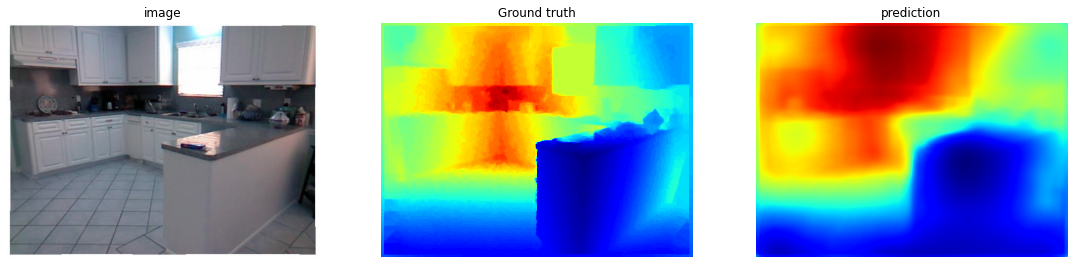

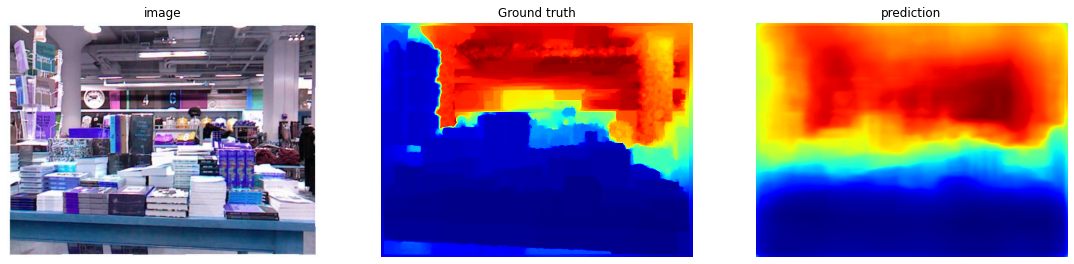

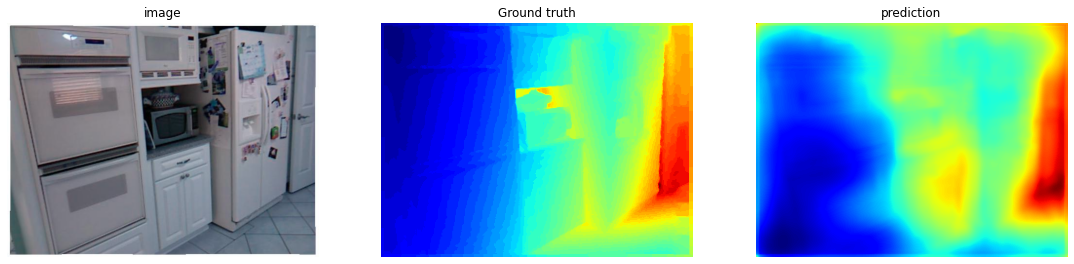

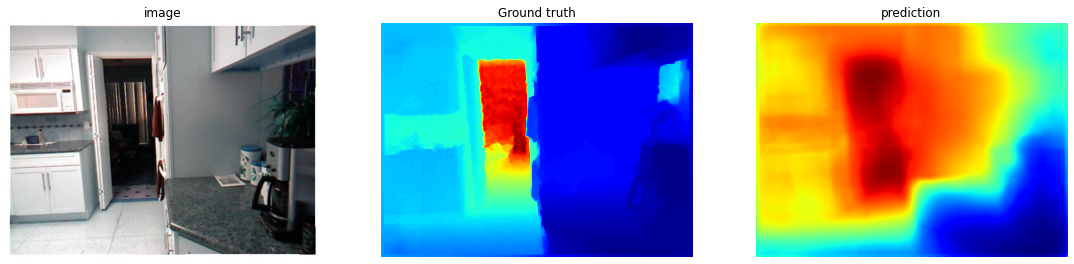

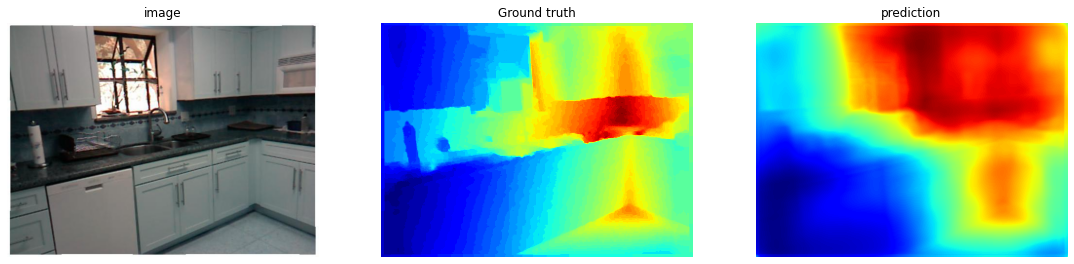

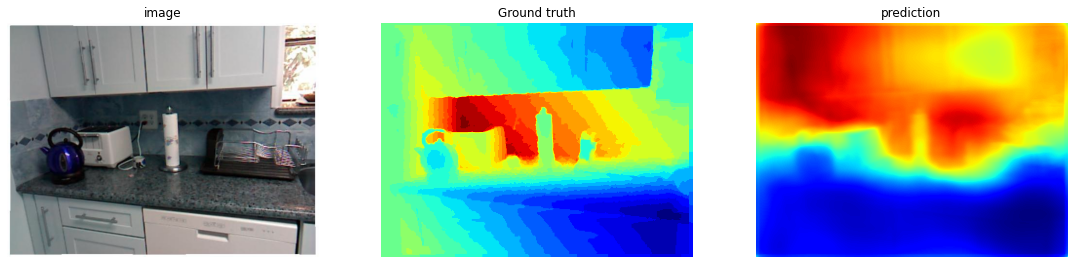

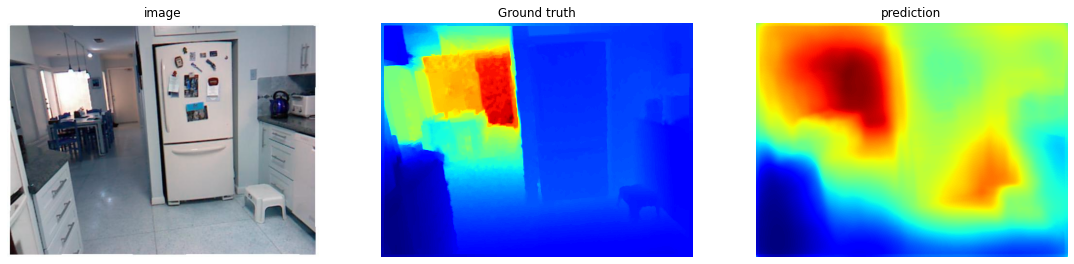

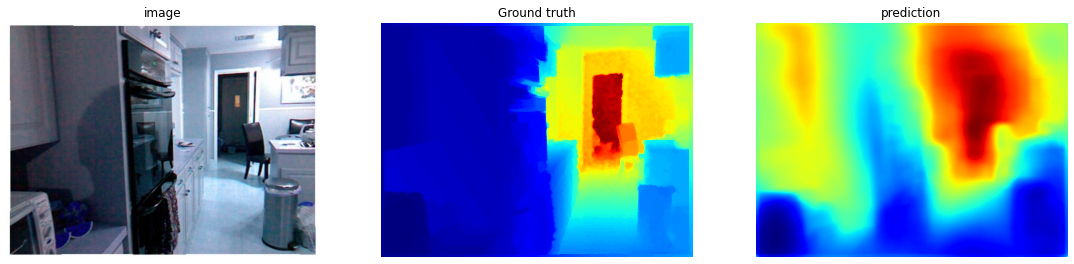

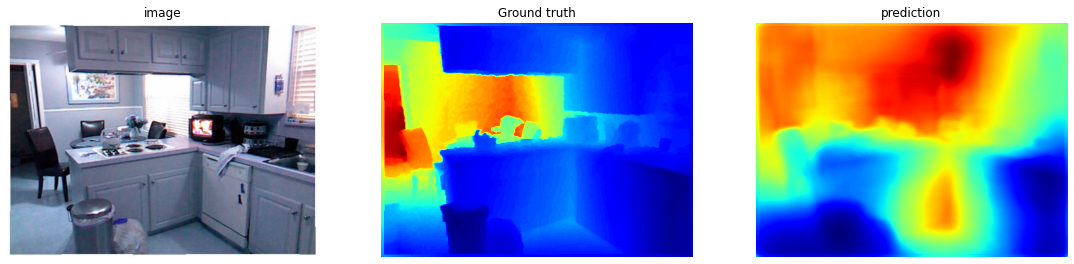

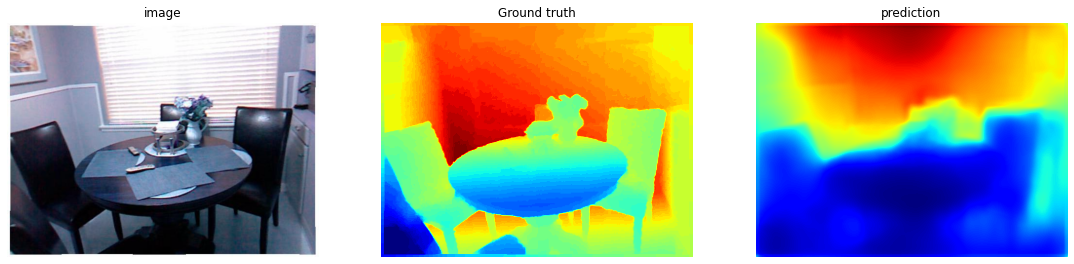

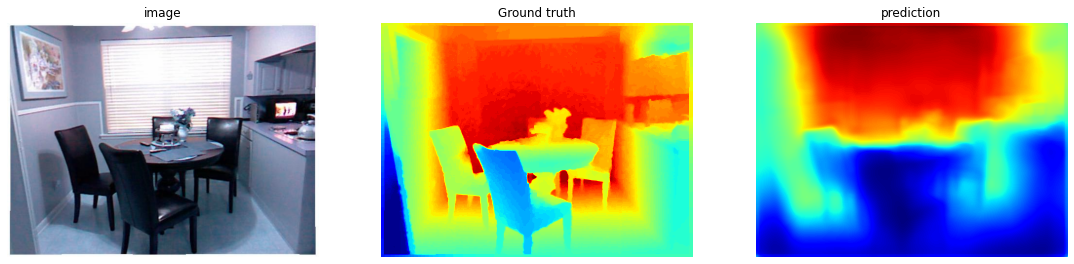

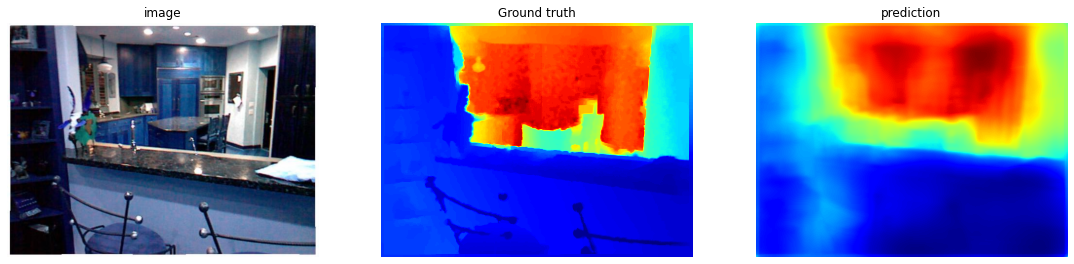

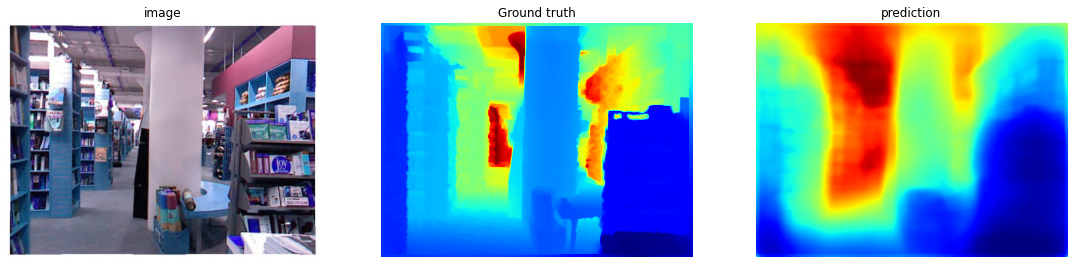

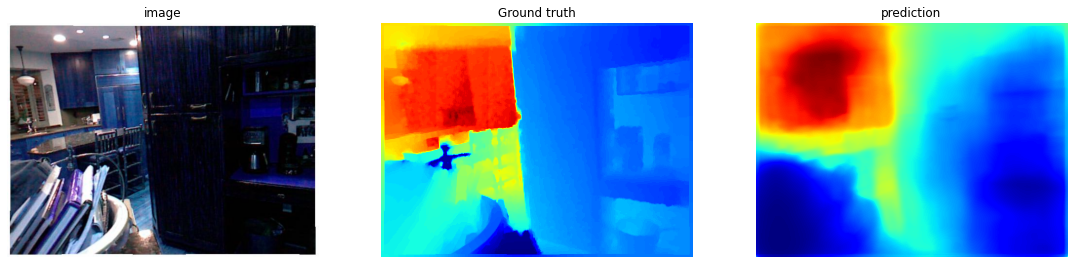

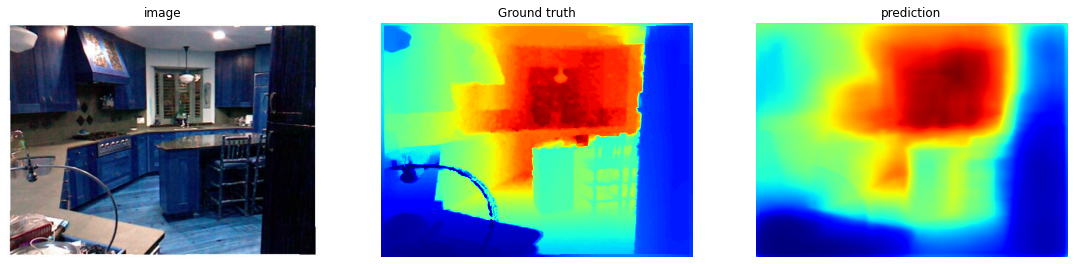

In [ ]:
#cmap = "plasma_r"
cmap = plt.cm.jet
cmap.set_bad(color="black")

for i in range(len(images)):
  plt.figure(figsize=(19,10))

  plt.subplot(1,3,1)
  plt.axis("off")
  img1 = images[i]
  plt.title("image")
  plt.imshow(img1)

  plt.subplot(1,3,2)
  plt.axis("off")
  img = labels[i]
  img = np.squeeze(img, axis=-1)
  plt.title("Ground truth")
  plt.imshow(img, cmap=plt.get_cmap(cmap))  

  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)
  plt.subplot(1,3,3)
  plt.axis("off")
  plt.title("prediction")
  plt.imshow(pred, cmap=plt.get_cmap(cmap))
  plt.show()

## Train generator

In [65]:
images,labels = next(iter(train_generator))
preds = model.predict(images)

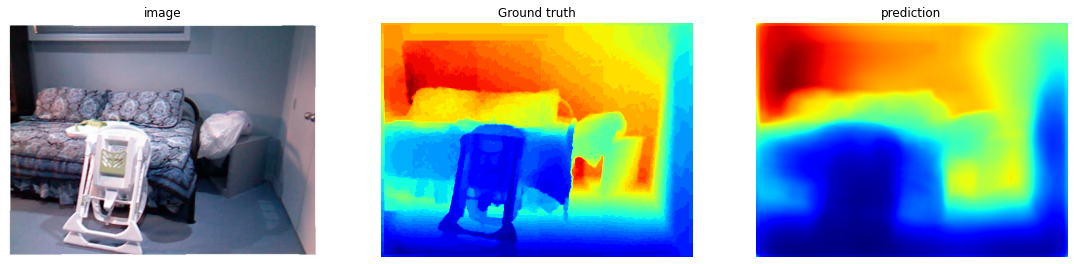

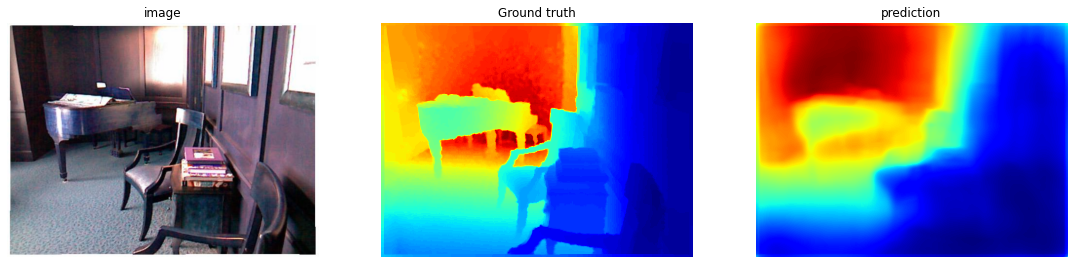

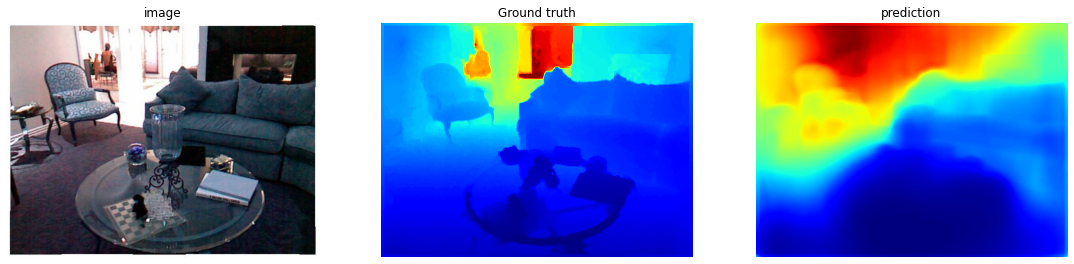

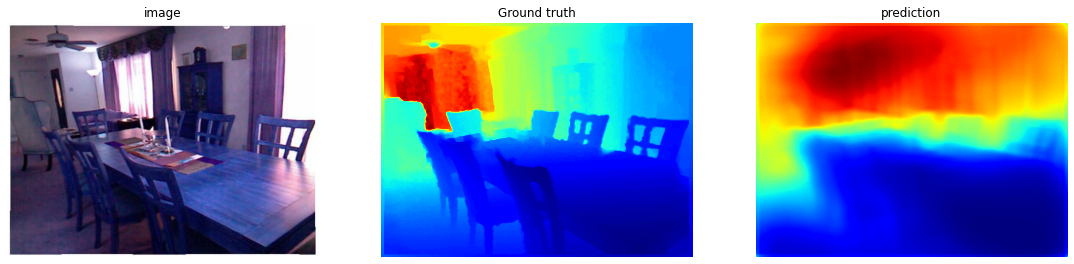

In [66]:
cmap = plt.cm.jet
cmap.set_bad(color="black")

for i in range(len(images)):
  plt.figure(figsize=(19,10))

  plt.subplot(1,3,1)
  plt.axis("off")
  img1 = images[i]
  plt.title("image")
  plt.imshow(img1)

  plt.subplot(1,3,2)
  plt.axis("off")
  img = labels[i]
  img = np.squeeze(img, axis=-1)
  plt.title("Ground truth")
  plt.imshow(img, cmap=plt.get_cmap(cmap))  

  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)
  plt.subplot(1,3,3)
  plt.axis("off")
  plt.title("prediction")
  plt.imshow(pred, cmap=plt.get_cmap(cmap))
  plt.show()

## Save model

In [ ]:
# 600 MB
# model.save('./models_depth/Unet/1.h5')

In [61]:
# serialize model to JSON
'''
model_json = model.to_json()
with open("./models_depth/Unet/1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./models_depth/Unet/1.h5")
print("Saved model to disk")
'''
# later...
'''
# load json and create model
from keras.models import model_from_json


json_file = open('./models_depth/Unet/1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("./models_depth/Unet/1.h5")
print("Loaded model from disk")
'''

'\n# load json and create model\nfrom keras.models import model_from_json\n\n\njson_file = open(\'./models_depth/Unet/1.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nmodel = model_from_json(loaded_model_json)\n# load weights into new model\nmodel.load_weights("./models_depth/Unet/1.h5")\nprint("Loaded model from disk")\n'

# Joint Object detection and Depth estimation

In [16]:
!mkdir -p Object_detection_web_app
!mkdir -p './Object_detection_web_app/Object_Detection/static'
!wget -nc https://pjreddie.com/media/files/yolov3.weights -P Object_detection_web_app
!wget -nc https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -P Object_detection_web_app
!wget -nc https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -P Object_detection_web_app

File ‘Object_detection_web_app/yolov3.weights’ already there; not retrieving.

File ‘Object_detection_web_app/coco.names’ already there; not retrieving.

File ‘Object_detection_web_app/yolov3.cfg’ already there; not retrieving.



In [62]:
# download our Unet depth model:
!mkdir -p './models_depth/Unet'
!gdown --id 1-crxkpHEx4c1zOvW1cwCWgrFjdkOv2-F -O ./models_depth/Unet/1.h5 # weights
!gdown --id 1-Z-tLbT3MRVujkcqORTSR5-i1vwaTSpQ -O ./models_depth/Unet/1.json # model(json file)
# load json and create model
from keras.models import model_from_json
json_file = open('./models_depth/Unet/1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("./models_depth/Unet/1.h5")
print("Loaded model from disk")

Downloading...
From: https://drive.google.com/uc?id=1-crxkpHEx4c1zOvW1cwCWgrFjdkOv2-F
To: /content/drive/MyDrive/Colab Notebooks/DL/project/models_depth/Unet/1.h5
100% 173M/173M [00:01<00:00, 99.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Z-tLbT3MRVujkcqORTSR5-i1vwaTSpQ
To: /content/drive/MyDrive/Colab Notebooks/DL/project/models_depth/Unet/1.json
100% 294k/294k [00:00<00:00, 76.2MB/s]
Loaded model from disk


In [67]:
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [68]:
def return_boxes(net, image, iou_thresh, nms_thresh, LABELS, threshold, state):

    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

    #jupyter
    image = cv2.resize(image,(640, 480)).astype(np.float32)
    image1 = image # dtype=float32, [0...1]
    image = image * 255
    image = image.astype(np.uint8) 
    #end jupyter

    #Depth
    rate = 0.3 # rate of the rectangle in the middle of each bounding box to estimate better depth
    res = (1-rate)/2
    dep_image = model.predict(np.expand_dims(image1, axis=0))[0].squeeze()
    dep_resized = cv2.resize(dep_image,(640, 480)).astype(np.float32)

    (H, W) = image.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]   #ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()
    # show timing information on YOLO
    detection_time = end - start


    boxes = []
    confidences = []
    classIDs = []

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:

            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > iou_thresh:
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, iou_thresh, nms_thresh)


    if len(idxs) > 0:
        for i in idxs.flatten():

            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            # Depth    
            depth_list = []     
            for ii in range(int(x+res*w), int(x+(res+rate)*w)):
              for j in range(int(y+res*h), int(y+(res+rate)*h)):
                depth_list.append(dep_resized[j, ii])
            Depth = (sum(depth_list) / len(depth_list)) * 9.99547

            if(state == 'MORE'):
              if(Depth >= threshold):
                color = [int(c) for c in COLORS[classIDs[i]]]
                cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
                #text = "{}: {:.2f}, Depth : {:.2f}".format(LABELS[classIDs[i]], confidences[i], Depth)
                text = "{}: {:.2f}".format(LABELS[classIDs[i]], confidences[i])
                cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                text = "Depth : {:.2f}".format(Depth)
                cv2.putText(image, text, (x, y + h +15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            if(state == 'LESS'):
              if(Depth < threshold):
                color = [int(c) for c in COLORS[classIDs[i]]]
                cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
                #text = "{}: {:.2f}, Depth : {:.2f}".format(LABELS[classIDs[i]], confidences[i], Depth)
                text = "{}: {:.2f}".format(LABELS[classIDs[i]], confidences[i])
                cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                text = "Depth : {:.2f}".format(Depth)
                cv2.putText(image, text, (x, y + h +15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)                

    #cv2.imshow("Image", image)

    #_, t = plt.subplots(1, 1)
    _, t = plt.subplots(1, 1, figsize=(15,7))
    t.imshow(image)
    plt.axis('off')
    plt.savefig("./Object_detection_web_app/Object_Detection/static/test.jpeg", dpi=360, bbox_inches='tight')

    return detection_time

In [69]:
def detection(original_image, threshold = 4.0, state = 'MORE'):
    cfg_file = './Object_detection_web_app/yolov3.cfg'
    weight_file = './Object_detection_web_app/yolov3.weights'
    names = './Object_detection_web_app/coco.names'

    m = cv2.dnn.readNetFromDarknet(cfg_file, weight_file)
    class_names = open(names).read().strip().split("\n")

    nms_thresh = 0.6
    iou_thresh = 0.4

    detection_time = return_boxes(m, original_image, iou_thresh, nms_thresh, class_names, threshold, state)

    return detection_time

# Test

In [70]:
# threshold in meter
threshold = 4.0
# more than of less than
state = 'MORE' # or 'LESS'

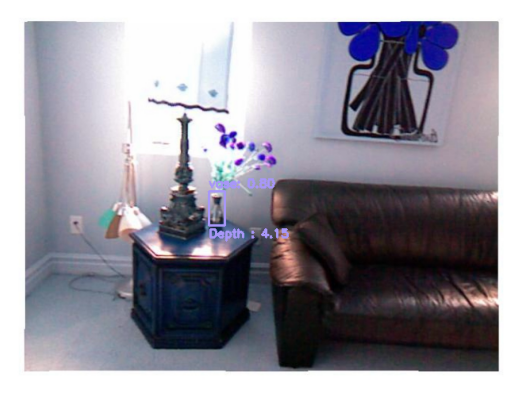

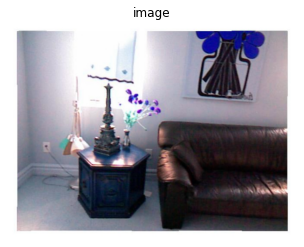

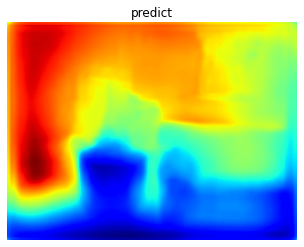

In [71]:
img = plt.imread('0.jpeg')
img = cv2.resize(img,(640, 480)).astype(np.float32)
# normalize image
img = img/255.0 
detection_time = detection(img, threshold, state)
plt.show()

plt.axis('off')
plt.imshow((np.expand_dims(img, axis=0))[0].squeeze())
plt.title('image')
plt.show()

plt.axis('off')
plt.imshow(model.predict(np.expand_dims(img, axis=0))[0].squeeze(), cmap=plt.get_cmap(cmap))
plt.title('predict')
plt.show()

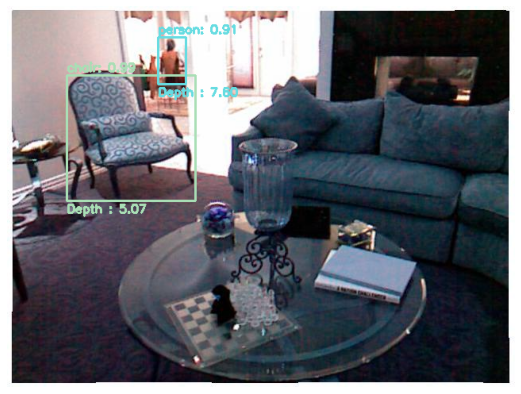

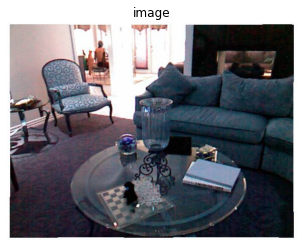

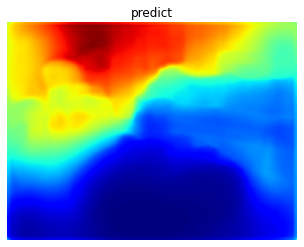

In [74]:
i = 2
img = images[i]
detection_time = detection(img)
plt.show()

plt.axis('off')
plt.imshow((np.expand_dims(images[i], axis=0))[0].squeeze())
plt.title('image')
plt.show()

plt.axis('off')
plt.imshow(model.predict(np.expand_dims(images[i], axis=0))[0].squeeze(), cmap=plt.get_cmap(cmap))
plt.title('predict')
plt.show()

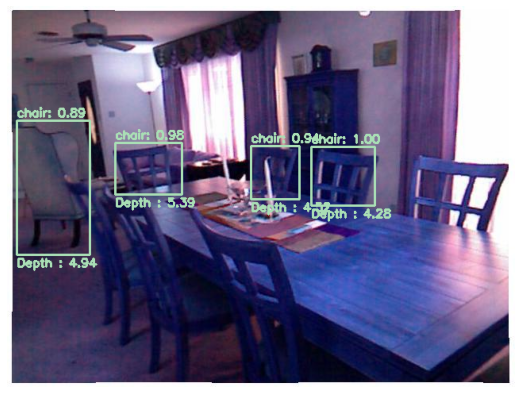

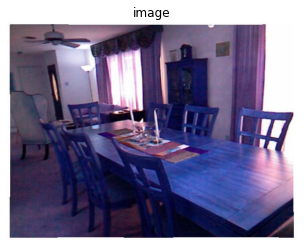

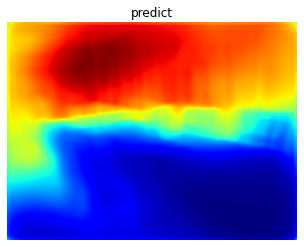

In [75]:
i = 3
img = images[i]
detection_time = detection(img)
plt.show()

plt.axis('off')
plt.imshow((np.expand_dims(images[i], axis=0))[0].squeeze())
plt.title('image')
plt.show()

plt.axis('off')
plt.imshow(model.predict(np.expand_dims(images[i], axis=0))[0].squeeze(), cmap=plt.get_cmap(cmap))
plt.title('predict')
plt.show()

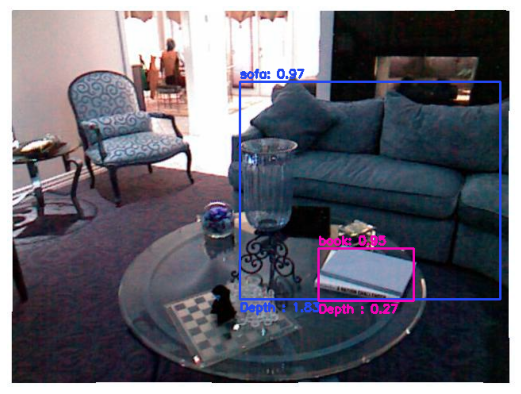

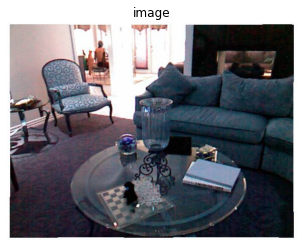

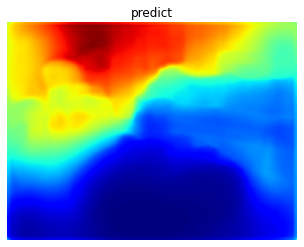

In [79]:
i = 2
img = images[i]
detection_time = detection(img, 4.0, 'LESS')
plt.show()

plt.axis('off')
plt.imshow((np.expand_dims(images[i], axis=0))[0].squeeze())
plt.title('image')
plt.show()

plt.axis('off')
plt.imshow(model.predict(np.expand_dims(images[i], axis=0))[0].squeeze(), cmap=plt.get_cmap(cmap))
plt.title('predict')
plt.show()